In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# mount your Google drive so that you only have to download the data only once
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
######load your data#######
import os
from os import walk
import numpy as np
# load your data
paths = ["/content/drive/MyDrive/sintesis_dataset/am","/content/drive/MyDrive/sintesis_dataset/fm",
         "/content/drive/MyDrive/sintesis_dataset/grain","/content/drive/MyDrive/sintesis_dataset/res",
         "/content/drive/MyDrive/sintesis_dataset/waveshapping"]
#print(paths)
audios = []
labels = []
labelsname = []
for i in paths:
    for (dirpath, dirnames, filenames) in walk(i):
        for filename in filenames:
            audios.append(os.path.join(dirpath, filename))
            #audios.append(filename)
            #print(audios)
            if filename.startswith("am"):
                labels.append(0)
                labelsname.append("am")
            elif filename.startswith("fm"):
                labels.append(1)
                labelsname.append("fm")
            elif filename.startswith("grain"):
                labels.append(2)
                labelsname.append("grain")
            elif filename.startswith("res"):
                labels.append(3)
                labelsname.append("res")
            elif filename.startswith("waveshapping"):
                labels.append(4)
                labelsname.append("waveshapping")
        #print(filenames)
        #audios.append(filenames)
        break


In [4]:
###rawwaveform
import librosa
import numpy as np

waveforms = []
#nsr = 22050

for track in audios:
    y,fs = librosa.load(track)
    #y = librosa.resample(y,fs,nsr)
    waveforms.append(y[:48000])#[...,np.newaxis][...,np.newaxis][...,np.newaxis])

#data = np.array(data)
#datastft = np.array(datastft)
waveforms = np.array(waveforms)

#print(data.shape)
#print(datastft.shape)
print(waveforms.shape)

(1000, 48000)


In [ ]:
#waveforms = waveforms.tolist()
waveforms = [waveforms[i] for i in range(0,1000,4)]
waveforms = np.array(waveforms)
print(waveforms.shape)


(250, 48000)


In [5]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]#[...,np.newaxis][...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]#[...,np.newaxis][...,np.newaxis]

Xw = (waveforms-mu_wave)/max_wave
#Xw = Xw
print(Xw.shape)

(1000, 48000)


In [21]:
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(1000, 48000, 1, 1)


In [ ]:
Ntracks = 250
track_idx = np.random.choice(Ntracks,Ntracks,replace=False)

### 85% de entrenamiento
### 100% de validación
### 50% de testeo

tr_tracks = [waveforms[i] for i in track_idx[:225]]
vl_tracks = [waveforms[i] for i in track_idx[225:]]

tr_tracks = np.array(tr_tracks)
vl_tracks = np.array(vl_tracks)
#print(len(tr_tracks))
print(tr_tracks.shape)
print(vl_tracks.shape)
#ts_tracks = [all_tracks[i] for i in track_idx[-50:]]

(225, 48000)
(25, 48000)


In [ ]:
Ntracks = 250
track_idx = np.random.choice(Ntracks,Ntracks,replace=False)
tr_tracks = [waveforms[i] for i in track_idx[0:]]
tr_tracks = np.array(tr_tracks)
print(tr_tracks.shape)

(250, 48000)


In [6]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [22]:
latent_dim = 128

encoder_inputs = keras.Input((48000, 1, 1))
x = layers.Conv2D(64, (4,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs)
x = layers.Conv2D(128,(4,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(4,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(4,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 12000, 1, 64  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 3000, 1, 128  32896       ['conv2d_12[0][0]']              
                                )                                                           

In [23]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(750 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((750, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(256,(4,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(128,(4,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (1, 1), activation="tanh", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 192000)            24768000  
                                                                 
 reshape_3 (Reshape)         (None, 750, 1, 256)       0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 3000, 1, 256)     262400    
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 12000, 1, 128)    131200    
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 48000, 1, 512)    2626

In [24]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
#vae.summary()
vae.compile(optimizer= tf.keras.optimizers.Adam())


vae.fit(Xw, epochs=200, batch_size= 20)

In [30]:
#display a 2D plot of the digit classes in the latent space
z_mean, _, _ = vae.encoder.predict(Xw)
print(z_mean[:10])
#plt.scatter(z_mean[0],z_mean[1], alpha=0.5)
#plt.show()

[[-1.93174928e-05  3.75031959e-05 -1.15326256e-05 ...  1.64709054e-05
  -4.84677730e-06  4.58960421e-05]
 [-1.99768692e-05  3.70605849e-05 -1.06690568e-05 ...  1.62399374e-05
  -4.50719381e-06  4.42881137e-05]
 [-1.94201712e-05  3.54838558e-05 -1.04155042e-05 ...  1.68618280e-05
  -5.80918277e-06  4.36322298e-05]
 ...
 [-2.02422962e-05  3.58156394e-05 -9.79792094e-06 ...  1.65596139e-05
  -4.59380681e-06  4.43509780e-05]
 [-1.99768692e-05  3.70605849e-05 -1.06690568e-05 ...  1.62399374e-05
  -4.50719381e-06  4.42881137e-05]
 [-2.24309042e-05  3.72061040e-05 -1.39280455e-05 ...  1.36827584e-05
  -5.96541213e-06  4.31116205e-05]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


NameError: ignored

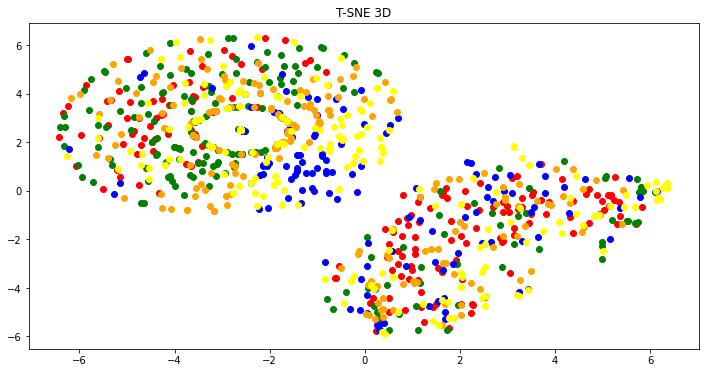

In [31]:
from sklearn.manifold import TSNE 

fig = plt.figure(1, figsize=(12, 6))
#a3x = Axes3D(fig,elev=-20, azim=100)
tsne = TSNE(n_components= 2)  # create an instance of t-SNE
#ax = plt.axes(projection = "3d")
X_tsne = tsne.fit_transform(z_mean)  # fit and transform the data
plt.scatter(X_tsne[:199, 0], X_tsne[:199, 1], c='red', label='am')
plt.scatter(X_tsne[200:399, 0], X_tsne[200:399, 1], c='green', label='fm')
plt.scatter(X_tsne[400:599, 0], X_tsne[400:599, 1], c='blue', label='grain')
plt.scatter(X_tsne[600:799, 0], X_tsne[600:799, 1], c='orange', label='res')
plt.scatter(X_tsne[800:999, 0], X_tsne[800:999, 1], c='yellow', label='waveshapping')
#ax.view_init(30,60)
plt.title('T-SNE 3D')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
#ax.set_zlabel('TSNE 3')
ax.legend()
plt.show()

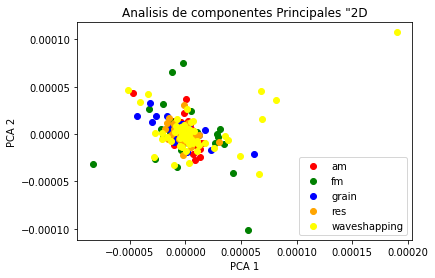

In [32]:
# plot ALL of your training data using t-SNE and PCA (must plot both)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)

# "transform" the data that you want to reduce to "two components"
X_PCA = pca.fit_transform(z_mean)

plt.scatter(X_PCA[:199, 0], X_PCA[:199, 1], c='red', label='am')
plt.scatter(X_PCA[200:399, 0], X_PCA[200:399, 1], c='green', label='fm')
plt.scatter(X_PCA[400:599, 0], X_PCA[400:599, 1], c='blue', label='grain')
plt.scatter(X_PCA[600:799, 0], X_PCA[600:799, 1], c='orange', label='res')
plt.scatter(X_PCA[800:999, 0], X_PCA[800:999, 1], c='yellow', label='waveshapping')

plt.legend()
plt.title('Analisis de componentes Principales "2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [33]:
a = vae.decoder.predict(z_mean)
print(a[:10])

[[[[ 0.01328748]]

  [[ 0.01664377]]

  [[ 0.01666276]]

  ...

  [[-0.01393998]]

  [[-0.01344469]]

  [[-0.01206748]]]


 [[[ 0.01328748]]

  [[ 0.01664376]]

  [[ 0.01666276]]

  ...

  [[-0.01393998]]

  [[-0.01344469]]

  [[-0.01206749]]]


 [[[ 0.01328748]]

  [[ 0.01664377]]

  [[ 0.01666276]]

  ...

  [[-0.01393998]]

  [[-0.01344469]]

  [[-0.01206749]]]


 ...


 [[[ 0.01328748]]

  [[ 0.01664377]]

  [[ 0.01666277]]

  ...

  [[-0.01393999]]

  [[-0.01344469]]

  [[-0.01206749]]]


 [[[ 0.01328748]]

  [[ 0.01664376]]

  [[ 0.01666276]]

  ...

  [[-0.01393998]]

  [[-0.01344469]]

  [[-0.01206749]]]


 [[[ 0.01328748]]

  [[ 0.01664377]]

  [[ 0.01666277]]

  ...

  [[-0.01393997]]

  [[-0.01344468]]

  [[-0.01206747]]]]


0
50
100
150
200


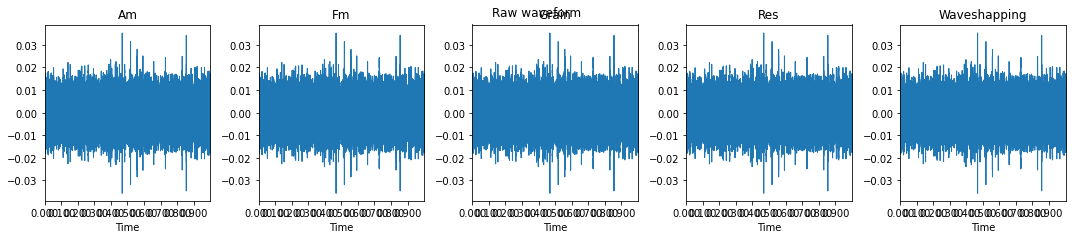

In [34]:
# visualize a few raw datapoints to get an idea about your "raw" data
# what are the units in the plot you are showing us?
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
sonidos = [0,50,100,150,200]
#sonidos = [i for i in range(5)]
labelsname = ["Am","Fm","Grain","Res","Waveshapping"]

for i, x in enumerate(sonidos):
    print(x)
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(a[x].flatten(),sr = 48000)
plt.tight_layout()

plt.show()

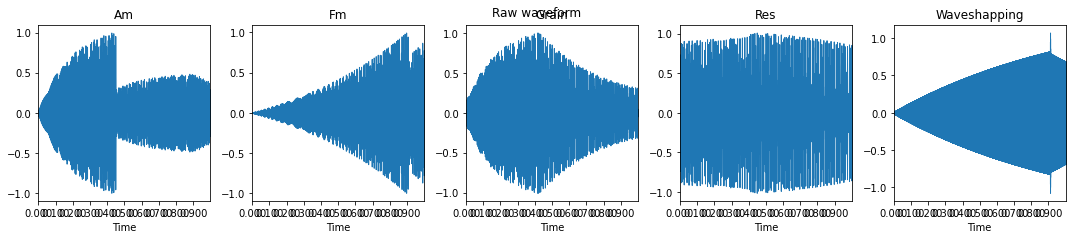

In [ ]:
# visualize a few raw datapoints to get an idea about your "raw" data
# what are the units in the plot you are showing us?
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(15, 6)).suptitle("Raw waveform")
sonidos = [0,50,100,150,200]
#sonidos = [i for i in range(5)]
labelsname = ["Am","Fm","Grain","Res","Waveshapping"]

for i, x in enumerate(sonidos):
    #print(x)
    plt.subplot(2, 5, i+ 1).set_title(labelsname[i])
    librosa.display.waveplot(Xw[x].flatten(), sr = 48000)
plt.tight_layout()

plt.show()